# Tuning and Validating Model Thresholds

In [52]:
%load_ext autoreload
%autoreload 2

In [1]:
# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd

from sklearn.metrics import recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from statannotations.Annotator import Annotator
from statannotations.stats.StatTest import StatTest

# Imports for analysis

# OS imports
from os.path import join as ospj
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'
jet_cmap = cm.get_cmap('Spectral')

In [2]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['font.family'] = 'Verdana'

In [3]:
def wideform_preds(element,all_labels):
    return [label in element for label in all_labels]

def shortform_preds(element,all_labels):
    a = np.array(all_labels)[element]
    return a
def apply_dice_score(row):
    all_chs = row.all_chs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row

def apply_kappa_score(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = wideform_preds(row[col],all_chs)
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(row[col+'_bool'],ch_preds)
    return row

def apply_specificity(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = np.atleast_1d(wideform_preds(row[col],all_chs))
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_spec'] = recall_score(row[col+'_bool']==False,ch_preds==False)
    return row

def apply_region_kappa(row):
    all_rs = row.all_rs
    for col in ['ueo_rs_strict','ueo_rs_loose','sec_rs_strict','ueo_rs_loose']:
        bool_col = wideform_preds(row[col],all_rs)
        for annot in ['consensus','any']:
            r_annots = wideform_preds(row[f'{col[:3]}_{annot}_rs'],all_rs)
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(bool_col,r_annots)
    return row

def apply_region_dice(row):
    all_rs = row.all_rs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row

def apply_mcc(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = wideform_preds(row[col],all_chs)
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_MCC'] = matthews_corrcoef(row[col+'_bool'],ch_preds)
    return row

## Config

In [4]:
usr,passpath,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/sauce/littlab/users/wojemann/stim-seizures/code','config.json'))

## Formatting Model Predictions

### Channel level

In [5]:
# # Loading in human annotations with consensus annotation already created
# annotations_df = pd.read_pickle(ospj(prodatapath,"threshold_tuning_consensus.pkl"))
# annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# # Loading in predicted channels for all models from generate_model_annotations.py
# predicted_channels = pd.read_pickle(ospj(prodatapath,"pretrain_predicted_channels_norsc_v2_nosmooth.pkl"))
# predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

# # Sorting
# predicted_channels.sort_values('approximate_onset',inplace=True)
# # predicted_channels = predicted_channels[predicted_channels.stim == 0]
# annotations_df.sort_values('approximate_onset',inplace=True)

# # Creating a merged table with human and machine annotations based on approximate seizure onset time
# pred_channels_wannots = pd.merge_asof(predicted_channels,
#                                     annotations_df[['approximate_onset','Patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
#                                     on='approximate_onset',by='Patient',
#                                     tolerance = 240,
#                                     direction='nearest')
# pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
# pred_channels_wannots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)
# pred_channels_wmcc = pred_channels_wannots.apply(apply_mcc,axis=1)
# # pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
# # # pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)
# # # # pred_channels_wspec = pred_channels_wannots.apply(apply_specificity,axis=1)

In [6]:
# pred_channels_wmcc.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wmcc_nosmooth.pkl"))
# # pred_channels_wspec.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wspec.pkl"))
# pred_channels_wdice.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wdice_norsc.pkl"))
# # pred_channels_wkappa.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wkappa_nor.pkl"))

### Calculating clinician consensus

In [7]:
consensus_annots = pd.read_pickle(ospj(prodatapath,'threshold_tuning_consensus.pkl'))
consensus_annots.loc[consensus_annots.Seizure_ID == 'HUP249_3','stim'] = 1.0
consensus_annots = consensus_annots[consensus_annots.patient != 'CHOP038']

In [8]:
# consensus_annots = consensus_annots[consensus_annots.stim == 0]
# Potentially put this back in for older version of results
consensus_annots = consensus_annots[consensus_annots.clinician.apply(lambda x: len(x)!=2)]
spread_consensus_annots = consensus_annots.copy()
note_type = 'ueo'
for i_r, row in consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]
    if len(annots) < 2: 
        continue
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += matthews_corrcoef(annots[i_annot],annots[j_annot])
    consensus_annots.loc[i_r,'f1'] = scores/(len(annots)*(len(annots)-1)/2)
consensus_annots["model"] = ["Clin."]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]

note_type = 'sec'
for i_r, row in spread_consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]
    if len(annots) < 2: 
        continue
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += matthews_corrcoef(annots[i_annot],annots[j_annot])
    spread_consensus_annots.loc[i_r,'f1'] = scores/(len(annots)*(len(annots)-1)/2)
spread_consensus_annots["model"] = ["Clin."]*len(spread_consensus_annots)
spread_consensus_annots["dice"] = spread_consensus_annots["f1"]

In [9]:
individual_annot_score = consensus_annots.copy()
note_type = 'ueo'
row_list = []
for i_r, row in individual_annot_score.iterrows():
    scores = 0
    annots = row[note_type]
    if len(annots) < 2: 
        continue
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            row_list.append({
                'model': row.clinician[i_annot],
                'patient': row.patient,
                'approximate_onset': row.approximate_onset,
                'stim': row.stim,
                'MCC': matthews_corrcoef(annots[i_annot],annots[j_annot])
            })
            row_list.append({
                'model': row.clinician[j_annot],
                'patient': row.patient,
                'approximate_onset': row.approximate_onset,
                'stim': row.stim,
                'MCC': matthews_corrcoef(annots[i_annot],annots[j_annot])
            })
individual_annot_df = pd.DataFrame(row_list)

0.6376232109228919


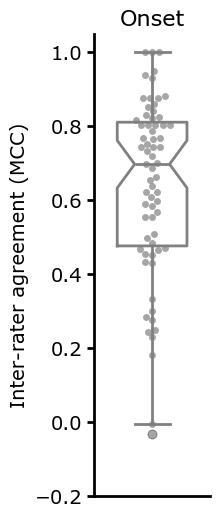

In [10]:
plt.figure(figsize=(1.5,6))
sns.boxplot(consensus_annots["dice"],color='gray',fill=False,notch=True,width=0.6)
sns.swarmplot(consensus_annots["dice"],color='gray',alpha=0.7)
# sns.pointplot(all_dice,color='gray',marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title('Onset');
plt.ylabel('Inter-rater agreement (MCC)');
plt.ylim([-.2,1.05]);
plt.xticks([]);
plt.savefig(ospj(figpath,'onset_interrater_agreement.pdf'),transparent=True,bbox_inches='tight')
print(consensus_annots.dice.mean())


0.6300707575586283


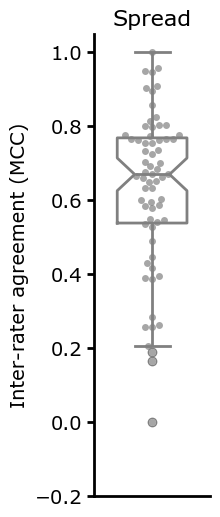

In [11]:
plt.figure(figsize=(1.5,6))
sns.boxplot(spread_consensus_annots["dice"],color='gray',fill=False,notch=True,width=.6)
sns.swarmplot(spread_consensus_annots["dice"],color='gray',alpha=0.7)
# sns.pointplot(all_dice,color='gray',marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title('Spread');
plt.ylabel('Inter-rater agreement (MCC)');
plt.ylim([-.2,1.05]);
plt.xticks([]);
plt.savefig(ospj(figpath,'spread_interrater_agreement.pdf'),transparent=True,bbox_inches='tight')
print(spread_consensus_annots.dice.mean())

In [12]:
sc.stats.mannwhitneyu(consensus_annots["dice"].dropna(),spread_consensus_annots["dice"].dropna())

MannwhitneyuResult(statistic=2366.5, pvalue=0.5887341464851064)

## Supervised Thresholding

### Data Prep

In [13]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
# mdl_preds = pd.read_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wmcc_nosmooth.pkl"))
# mdl_preds = pd.read_pickle('/mnt/sauce/littlab/users/wojemann/stim-seizures/PROCESSED_DATA/pretrain_predicted_channels_wmcc_epoch-10_min-False_mov-mean-20-prob.pkl')
mdl_preds = pd.read_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wmcc_epoch-10_min-False_mov-mean-20-prob_v2.pkl"))
mdl_preds = mdl_preds[mdl_preds.model != 'NRG']
mdl_preds.loc[mdl_preds.approximate_onset == 439029.32,'stim'] = 1.0
# mdl_preds = mdl_preds[mdl_preds.stim == 0]

In [14]:
print(len(mdl_preds[mdl_preds.stim==1].approximate_onset.unique()))
print(mdl_preds.approximate_onset.nunique())
print(len(mdl_preds.Patient.unique()))
print(len(mdl_preds[mdl_preds.Patient.apply(lambda x: 'HUP' in x)].Patient.unique()))
print(len(mdl_preds[mdl_preds.Patient.apply(lambda x: 'HUP' in x)].approximate_onset.unique()))

36
80
29
19
63


In [15]:
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])

In [16]:
# melt_cols = [f'ueo_{anntype}_{mdl_anntype}_dice',f'sec_{anntype}_{mdl_anntype}_dice']
melt_cols = [f'ueo_chs_{mdl_anntype}_{anntype}_MCC',f'sec_chs_{mdl_anntype}_{anntype}_MCC']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='dice')
# mdl_preds_long.Patient.unique()

In [17]:
# tune_preds_long = mdl_preds_long[mdl_preds_long.annot == 'ueo_consensus_loose_dice']
# val_preds_long = mdl_preds_long[mdl_preds_long.annot == 'sec_consensus_loose_dice']
tune_preds_long = mdl_preds_long[mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC']
val_preds_long = mdl_preds_long[mdl_preds_long.annot == f'sec_chs_{mdl_anntype}_{anntype}_MCC']

### Threshold sweeping

In [18]:
mdl_preds_long.Patient.unique()

array(['CHOP005', 'CHOP024', 'CHOP026', 'CHOP028', 'CHOP035', 'CHOP037',
       'CHOP041', 'CHOP044', 'CHOP045', 'CHOP049', 'HUP224', 'HUP225',
       'HUP229', 'HUP230', 'HUP235', 'HUP238', 'HUP246', 'HUP247',
       'HUP249', 'HUP250', 'HUP253', 'HUP257', 'HUP261', 'HUP263',
       'HUP266', 'HUP267', 'HUP273', 'HUP275', 'HUP288'], dtype=object)

#### Comparing thesholds by stim

In [19]:
# fig,axs = plt.subplots(1,2)
# sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC'],x='threshold',y='dice',hue='model',ax=axs[0])
# axs[0].set_ylim((-.1,.7))
# axs[0].set_title('Onset Annots')
# # axs[0].axvline(1.33)
# sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_chs_{mdl_anntype}_{anntype}_MCC'],x='threshold',y='dice',hue='model',ax=axs[1],legend=False)
# axs[1].set_ylim((-.1,.7))
# axs[1].set_yticks([])
# axs[1].set_ylabel('')
# axs[1].set_title('Spread Annots')
# fig.suptitle(f'Model Annotator Agreement - {anntype}')
# # fig.savefig(ospj(figpath,f'ueo_ch_dice_{anntype}-{mdl_anntype}.pdf'),transparent=True)

In [20]:
print(mdl_preds_sorted[(mdl_preds_sorted.model == 'LSTM') & (mdl_preds_sorted.stim==0)].groupby('threshold')['ueo_chs_strict_consensus_MCC'].median().idxmax())
print(mdl_preds_sorted[(mdl_preds_sorted.model == 'LSTM') & (mdl_preds_sorted.stim==1)].groupby('threshold')['ueo_chs_strict_consensus_MCC'].median().idxmax())
print(mdl_preds_sorted[(mdl_preds_sorted.model == 'LSTM')].groupby('threshold')['ueo_chs_strict_consensus_MCC'].mean().idxmax())

1.479305740987984
2.205607476635514
1.479305740987984


In [21]:
opt_thresh_df = (
    mdl_preds_sorted[mdl_preds_sorted.model == 'LSTM']
    .groupby(['stim', 'approximate_onset', 'threshold'])['ueo_chs_strict_consensus_MCC']
    .mean()
    .reset_index()
    .sort_values(['stim', 'approximate_onset', 'ueo_chs_strict_consensus_MCC'], ascending=[True, True, False])
    .groupby(['stim', 'approximate_onset'])
    .first()
    .reset_index()
)
opt_thresh_df['stim'] = opt_thresh_df['stim'].map({1.0:'Stim',0.0:'Spont'})
opt_thresh_df.rename(columns={'stim':'Sz Type'},inplace=True)

opt_thresh_ptdf = (
    mdl_preds_sorted[mdl_preds_sorted.model == 'LSTM']
    .groupby(['stim', 'Patient', 'threshold'])['ueo_chs_strict_consensus_MCC']
    .mean()
    .reset_index()
    .sort_values(['stim', 'Patient', 'ueo_chs_strict_consensus_MCC'], ascending=[True, True, False])
    .groupby(['stim', 'Patient'])
    .first()
    .reset_index()
)
opt_thresh_ptdf['stim'] = opt_thresh_ptdf['stim'].map({1.0:'Stim',0.0:'Spont'})
opt_thresh_ptdf.rename(columns={'stim':'Sz Type'},inplace=True)

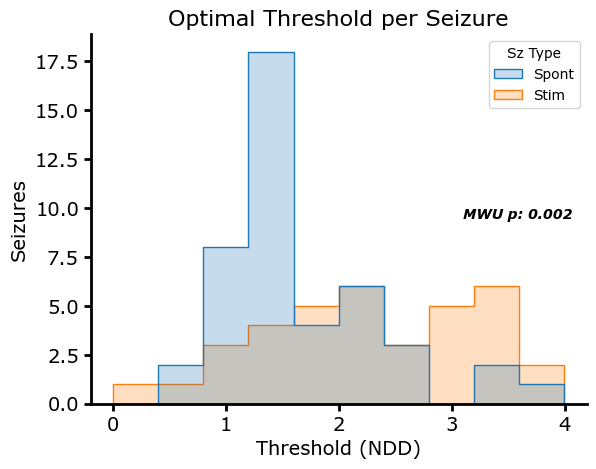

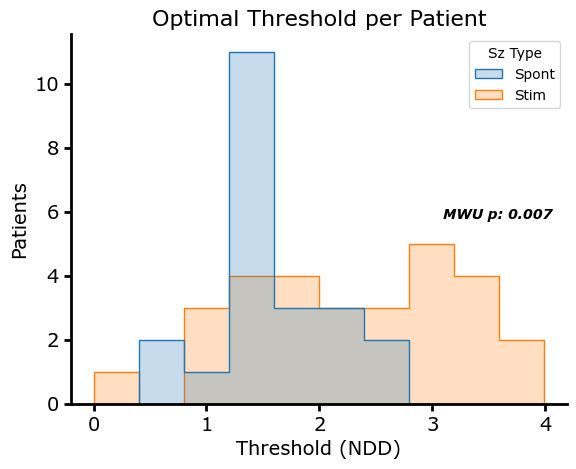

In [22]:
ax = sns.histplot(opt_thresh_df,x='threshold',hue='Sz Type',element='step',bins=10)
sns.despine()
plt.ylabel('Seizures')
plt.xlabel('Threshold (NDD)')
p = np.round(sc.stats.mannwhitneyu(opt_thresh_df.query('`Sz Type`=="Spont"').threshold,opt_thresh_df.query('`Sz Type`=="Stim"').threshold).pvalue,3)
plt.text(.75,.5,
f'MWU p: {p}',
transform=ax.transAxes,
fontdict=dict(weight='bold',style='italic'))
plt.title('Optimal Threshold per Seizure')
plt.show()

ax = sns.histplot(opt_thresh_ptdf,x='threshold',hue='Sz Type',element='step',bins=10)
sns.despine()
plt.ylabel('Patients')
plt.xlabel('Threshold (NDD)')
p = np.round(sc.stats.mannwhitneyu(opt_thresh_ptdf.query('`Sz Type`=="Spont"').threshold,opt_thresh_ptdf.query('`Sz Type`=="Stim"').threshold).pvalue,3)
plt.text(.75,.5,
f'MWU p: {p}',
transform=ax.transAxes,
fontdict=dict(weight='bold',style='italic'))
plt.title('Optimal Threshold per Patient')
plt.show()

#### LOPO CVAL

Population average AbsSlp threshold: (0.1281708945260347, array([0.12817089, 0.13351135]))
Cross-validated estimation of AbsSlp MCC: 0.1391830883222735


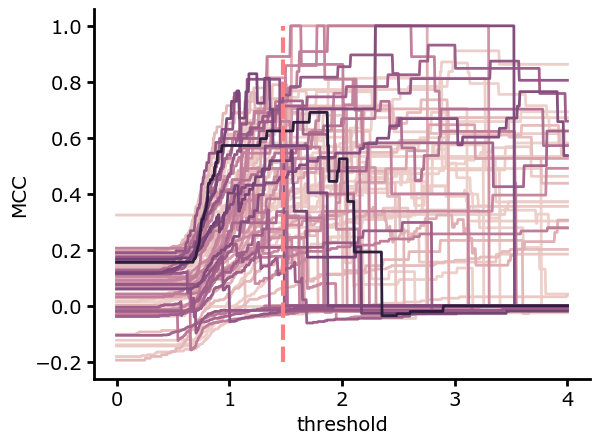

1.479305740987984
Population average LSTM threshold: (1.479305740987984, array([1.47930574, 1.47930574]))
Cross-validated estimation of LSTM MCC: 0.48958132856941056
Population average WVNT threshold: (0.37917222963951935, array([0.29906542, 0.38451268]))
Cross-validated estimation of WVNT MCC: 0.34651116538268756


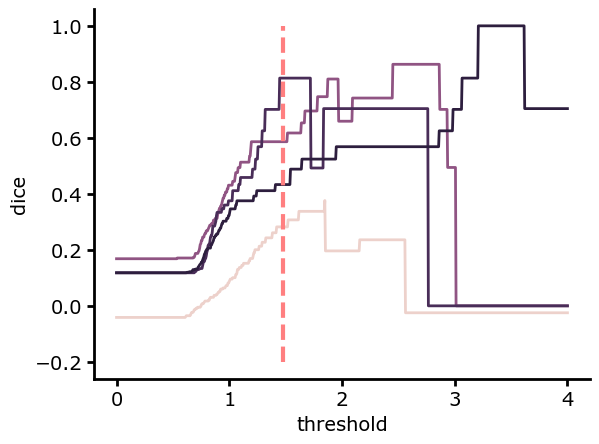

In [23]:
from sklearn.model_selection import KFold
dict_list = []
for model in mdl_preds_sorted.model.unique():   
    # Assuming the DataFrame is named 'df' and already loaded
    df = mdl_preds_sorted[(mdl_preds_sorted['model'] == model) & (mdl_preds_sorted['stim'] == 0)]
    # Get unique patients
    unique_patients = df['Patient'].unique()

    # Create a KFold object to split patients
    kf = KFold(n_splits=len(unique_patients)-1, shuffle=False)
    # len(unique_patients)-1
    optimal_thresholds = []
    cross_validated_mccs = []

    for fold, (train_index, test_index) in enumerate(kf.split(unique_patients), 1):
        train_patients = unique_patients[train_index]
        test_patients = unique_patients[test_index]

        # Create training and test DataFrames based on patient splits
        train_df = df[df['Patient'].isin(train_patients)]
        test_df = df[df['Patient'].isin(test_patients)]

        # Calculate average MCC for each threshold in the training set
        average_mcc_per_threshold = train_df.groupby('threshold')['ueo_chs_strict_consensus_MCC'].median()

        # Find the optimal threshold
        optimal_threshold = average_mcc_per_threshold.idxmax()
        optimal_thresholds.append(optimal_threshold)
        
        # Calculate MCC for each seizure in the test set at the optimal threshold
        test_seizures = test_df[test_df['threshold'] == optimal_threshold]
        for onset, seizure in test_seizures.groupby('approximate_onset'):
            cross_validated_mccs.extend(seizure['ueo_chs_strict_consensus_MCC'].values)
            dict_list.append({
                'patient': seizure.Patient.values[0],
                'approximate_onset': onset,
                'model': model,
                'stim': seizure.stim.values[0],
                'dice': seizure['ueo_chs_strict_consensus_MCC'].values[0],
                'threshold': optimal_threshold
            })
            if (test_df.Patient.iloc[0] == 'HUP238') & (onset == 290006.91) &(test_df.model.iloc[0] == 'LSTM'):
                ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.Patient != 'HUP238') & (mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC') & (mdl_preds_long.model == 'LSTM')],
                hue_order='Patient',
                x='threshold',
                y='dice',
                hue='approximate_onset',
                # palette='spring_r',
                errorbar=None,legend=False)
                ax.plot([optimal_threshold,optimal_threshold],[-.2,1],
                c=sns.color_palette('spring_r',n_colors=3)[1],
                linewidth=3,
                linestyle='--')
                plt.ylabel('MCC')
                sns.despine()
                plt.show()

                bx = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.Patient == 'HUP238') & (mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC') & (mdl_preds_long.model == 'LSTM')],
                hue_order='Patient',
                x='threshold',
                y='dice',
                hue='approximate_onset',
                color='purple',
                errorbar=None,legend=False)
                bx.plot([optimal_threshold,optimal_threshold],
                [-.2,1],
                c=sns.color_palette('spring_r',n_colors=3)[1],
                linestyle='--',
                linewidth=3)
                sns.despine()
                print(optimal_threshold)
    # Calculate the population average threshold
    population_average_threshold = np.median(optimal_thresholds)

    # Calculate the cross-validated estimation of MCC
    cross_validated_mcc = np.median(cross_validated_mccs)

    print(f"Population average {model} threshold: {population_average_threshold,np.percentile(optimal_thresholds,[25,75])}")
    print(f"Cross-validated estimation of {model} MCC: {cross_validated_mcc}")
cval_preds = pd.DataFrame(dict_list)
cval_preds.loc[cval_preds.model == 'LSTM','model'] = 'NDD'
cval_preds.loc[cval_preds.model == 'WVNT','model'] = 'DL'

Text(0.5, 1.0, 'LOPO Onset Activity Detection')

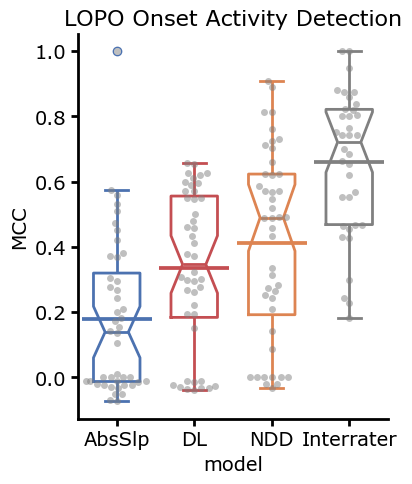

In [24]:
consensus_annots["model"] = ["Interrater"]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]
cval_consensus_annots = consensus_annots[consensus_annots.stim == 0]
cval_plot_agreements = pd.concat([cval_preds,cval_consensus_annots[['patient',"model","dice","stim"]]]).dropna(subset='dice').reset_index(drop=True)
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[0,3,1]]
_,ax = plt.subplots(figsize=(4,5))
sns.boxplot(cval_plot_agreements,x='model',y='dice',hue='model',palette=np.vstack([colors,[.5,.5,.5]]),
                 order=['AbsSlp','DL','NDD','Interrater'],
                 hue_order=['AbsSlp','DL','NDD','Interrater'],
                 width=.6,notch=True,fill=False,
                 ax=ax)

sns.swarmplot(cval_plot_agreements,x='model',y='dice',color='gray',ax=ax,alpha=0.5)
sns.pointplot(cval_plot_agreements,x='model',y='dice',
              palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              hue_order = ['AbsSlp','DL','NDD','Interrater'],
              order = ['AbsSlp','DL','NDD','Interrater'],
              marker='_',markersize=50,errorbar=None,
              estimator='mean',
              ax=ax)

sns.despine()
plt.ylabel('MCC')
plt.title('LOPO Onset Activity Detection')

In [25]:
all_ps = []
mdl_strs = cval_plot_agreements.model.unique()
for idx_mdl in range(len(mdl_strs)):
    for jdx_mdl in range(idx_mdl+1,len(mdl_strs)):
        i_mdl = mdl_strs[idx_mdl]
        j_mdl = mdl_strs[jdx_mdl]
        if (i_mdl != 'NDD') & (j_mdl != 'NDD'):
            continue
        print(i_mdl,j_mdl)
        print(np.median(cval_plot_agreements[cval_plot_agreements.model == i_mdl]['dice']), np.mean(cval_plot_agreements[cval_plot_agreements.model == j_mdl]['dice']))
        stat,p = sc.stats.mannwhitneyu(cval_plot_agreements[cval_plot_agreements.model == i_mdl]['dice'],cval_plot_agreements[cval_plot_agreements.model == j_mdl]['dice'])
        d=cohens_d(cval_plot_agreements[cval_plot_agreements.model == i_mdl]['dice'],
                 cval_plot_agreements[cval_plot_agreements.model == j_mdl]['dice'])
        all_ps.append(p)
        print(stat,p)
multipletests(all_ps[:2])

AbsSlp NDD
0.1391830883222735 0.4120860586124145
487.5 6.105805262925238e-05
NDD DL
0.48958132856941056 0.33440998931566984
1154.0 0.12153809084481748
NDD Interrater
0.48958132856941056 0.6593516723310396
416.0 0.000280877776633053


(array([ True, False]),
 array([0.00012211, 0.12153809]),
 0.025320565519103666,
 0.025)

#### Individual plotting

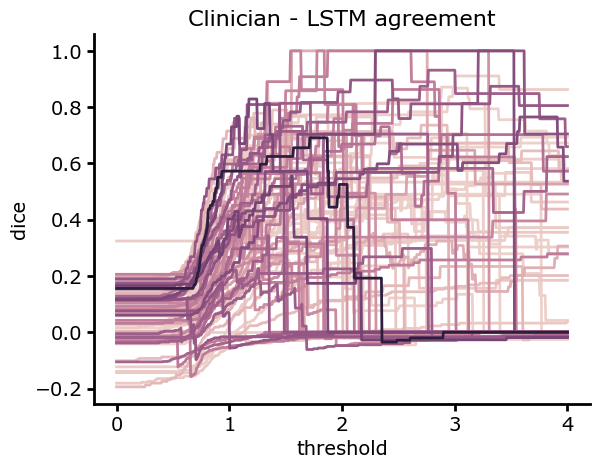

In [26]:
fig,ax = plt.subplots()
# ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice') & (mdl_preds_long.model == 'LSTM')],hue_order='Patient',x='threshold',y='dice',hue='approximate_onset',errorbar=None,legend=False)
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC') & (mdl_preds_long.model == 'LSTM')],hue_order='Patient',x='threshold',y='dice',hue='approximate_onset',errorbar=None,legend=False)

# plt.xlim([0,1])
plt.title('Clinician - LSTM agreement')
sns.despine()
# fig.savefig(ospj(figpath,f'pt_LSTM_ueo_ch_dice_{anntype}-{mdl_anntype}.pdf'),transparent=True)

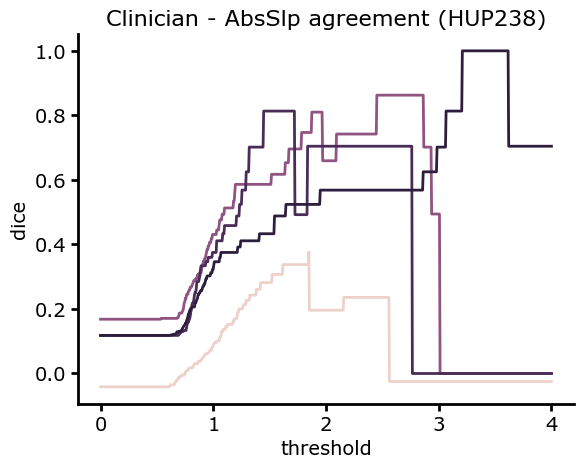

In [27]:
# ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice') & (mdl_preds_long.model == 'AbsSlp')& (mdl_preds_long.Patient == 'HUP238')],x='threshold',y='dice',hue='approximate_onset',errorbar=None,legend=False)
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC') & (mdl_preds_long.model == 'LSTM')& (mdl_preds_long.Patient == 'HUP238')],x='threshold',y='dice',hue='approximate_onset',errorbar=None,legend=False)
# plt.xlim([0,1])
plt.title('Clinician - AbsSlp agreement (HUP238)')
sns.despine()


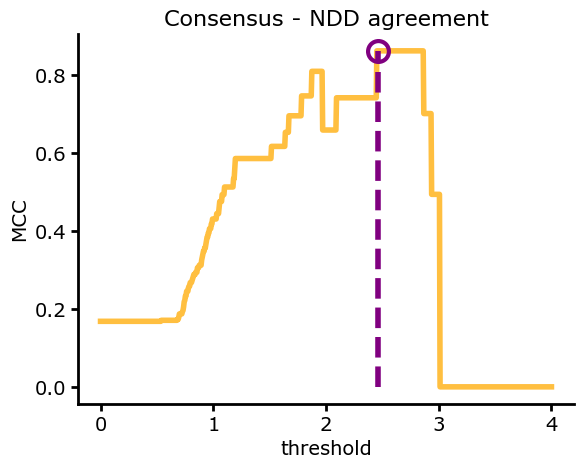

In [28]:
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC') & (mdl_preds_long.model == 'LSTM')& (mdl_preds_long.Patient == 'HUP238')& (mdl_preds_long.approximate_onset == 290006.91)],
x='threshold',y='dice',
color=sns.color_palette('spring_r',n_colors=3)[0],
errorbar=None,
legend=False,
linewidth=4)
# plt.xlim([0,1])
# plt.axvline(2.4085447263017357,c='black',linestyle='--')
ax.plot([2.4585447263017357]*2,[0,0.8626358588651414],'--o',c='purple',
markersize=15,
linewidth=4,
markevery=[1],
fillstyle='none',
markeredgewidth=3)
plt.title('Consensus - NDD agreement')
plt.ylabel('MCC')
sns.despine()

### Tuning at the seizure level

#### Tuning and testing on onset

In [29]:
optimal_threshold_preds = tune_preds_long.loc[tune_preds_long.groupby(['Patient', 'approximate_onset','model'])['dice'].idxmax()][["model","dice","Patient","stim","approximate_onset",'threshold']]#,'ueo_chs_loose','ueo_consensus_chs']]

In [30]:
consensus_annots["model"] = ["Clin."]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]
# consensus_annots = consensus_annots[consensus_annots.stim == 0]
all_plot_agreements = pd.concat([optimal_threshold_preds,consensus_annots[["model","dice","stim"]]]).dropna(subset='dice')

In [31]:
for mdl in optimal_threshold_preds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(consensus_annots.f1.dropna(),optimal_threshold_preds[optimal_threshold_preds.model == mdl].dice,alternative='greater'))

AbsSlp
MannwhitneyuResult(statistic=3750.0, pvalue=1.5925727841374465e-05)
LSTM
MannwhitneyuResult(statistic=3073.5, pvalue=0.06315985242586487)
WVNT
MannwhitneyuResult(statistic=3573.5, pvalue=0.0002570088015057069)


In [32]:
# all_plot_agreements = pd.concat([all_plot_agreements,external_annots])
all_plot_agreements = all_plot_agreements[all_plot_agreements.model != 'NRG']
all_plot_agreements.loc[all_plot_agreements.model == 'LSTM',['model']] = 'NDD'
all_plot_agreements.loc[all_plot_agreements.model == 'WVNT',['model']] = 'DL'
all_plot_agreements.loc[all_plot_agreements.model == 'Clin.',['model']] = 'Interrater'

In [33]:
all_plot_agreements[all_plot_agreements.model == 'NDD'].approximate_onset.count()

80

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DL vs. NDD: One-sided MannWhitney U statistical test with Benjamini-Hochberg correction, P_val:3.366e-02 Stat=2.664e+03
AbsSlp vs. NDD: One-sided MannWhitney U statistical test with Benjamini-Hochberg correction, P_val:4.424e-03 Stat=2.432e+03


([0, 1, 2, 3],
 [Text(0, 0, 'AbsSlp'),
  Text(1, 0, 'DL'),
  Text(2, 0, 'NDD'),
  Text(3, 0, 'Interrater')])

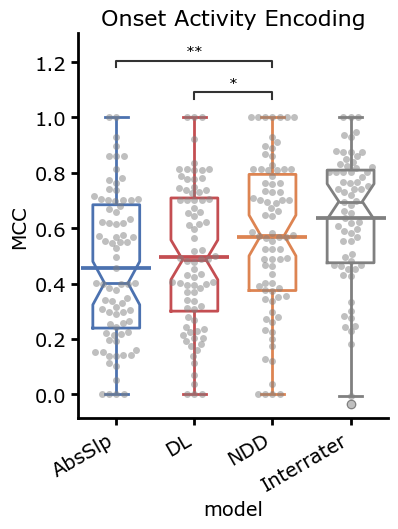

In [34]:
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[0,3,1]]
_,ax = plt.subplots(figsize=(4,5))
sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([colors,[.5,.5,.5]]),
                 order=['AbsSlp','DL','NDD','Interrater'],
                 width=.6,notch=True,fill=False,ax=ax)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray',ax=ax,alpha=0.5)
sns.pointplot(all_plot_agreements,x='model',y='dice',
              palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','DL','NDD','Interrater'],
              marker='_',markersize=50,errorbar=None,ax=ax,
              estimator='mean')
sns.despine()

# Required descriptors for annotate
custom_long_name = 'One-sided MannWhitney U statistical test'
custom_short_name = 'MWUG'
def custom_stat(x,y):
    return sc.stats.mannwhitneyu(x,y,alternative='less')
custom_test = StatTest(custom_stat, custom_long_name, custom_short_name)

# Annotating plot
annotator = Annotator(ax,[('NDD','DL'),('NDD','AbsSlp')],data=all_plot_agreements,order=['AbsSlp','DL','NDD','Interrater'],x='model',y='dice')
annotator.configure(test=custom_test,loc='inside',text_format='star',comparisons_correction="Benjamini-Hochberg")
annotator.apply_and_annotate()

plt.ylabel('MCC')
plt.title("Onset Activity Encoding")
plt.xticks(rotation=30,ha='right')
# plt.savefig(ospj(figpath,'onset_tuned_onset_detection.pdf'),bbox_inches='tight')

In [35]:
all_ps = []
mdl_strs = all_plot_agreements.model.unique()
for idx_mdl in range(len(mdl_strs)):
    for jdx_mdl in range(len(mdl_strs)):
        if idx_mdl == jdx_mdl:
            continue
        i_mdl = mdl_strs[idx_mdl]
        j_mdl = mdl_strs[jdx_mdl]
        if (i_mdl != 'NDD'):# & (j_mdl != 'NDD'):
            continue
        print(i_mdl,j_mdl)
        print(np.median(all_plot_agreements[all_plot_agreements.model == i_mdl]['dice']), np.mean(all_plot_agreements[all_plot_agreements.model == j_mdl]['dice']))
        stat,p = sc.stats.mannwhitneyu(all_plot_agreements[all_plot_agreements.model == i_mdl]['dice'],all_plot_agreements[all_plot_agreements.model == j_mdl]['dice'],alternative='greater')
        d=cohens_d(all_plot_agreements[all_plot_agreements.model == i_mdl]['dice'],
                 all_plot_agreements[all_plot_agreements.model == j_mdl]['dice'])
        all_ps.append(p)
        print(stat,p)
multipletests(all_ps[:2])

NDD AbsSlp
0.573870604841225 0.4570513965032525
3967.5 0.004423760580424495
NDD DL
0.573870604841225 0.4944747941958322
3736.5 0.03366389601603341
NDD Interrater
0.573870604841225 0.637623210922892
2286.5 0.9373210557187455


(array([ True,  True]),
 array([0.00882795, 0.0336639 ]),
 0.025320565519103666,
 0.025)

#### Testing on spread

In [36]:
val_tuned_thresholds = val_preds_long[['Patient','approximate_onset','model','threshold','dice']].merge(optimal_threshold_preds[['Patient','approximate_onset','model','threshold']],on=['Patient','approximate_onset','model','threshold'],how='inner')

In [37]:
val_tuned_thresholds = val_preds_long.loc[val_preds_long.groupby(['Patient', 'approximate_onset','model'])['dice'].idxmax()][["model","dice","Patient","stim","approximate_onset",'threshold']]#,'ueo_chs_loose','ueo_consensus_chs']]

In [38]:
spread_consensus_annots["model"] = ["Clin."]*len(spread_consensus_annots)
spread_consensus_annots = spread_consensus_annots[spread_consensus_annots.stim == 0]
all_plot_agreements = pd.concat([val_tuned_thresholds,spread_consensus_annots[["model","dice"]]])

In [39]:
all_plot_agreements = all_plot_agreements[all_plot_agreements.model != 'NRG']
all_plot_agreements.loc[all_plot_agreements.model == 'LSTM',['model']] = 'NDD'
all_plot_agreements.loc[all_plot_agreements.model == 'WVNT',['model']] = 'DL'
all_plot_agreements.loc[all_plot_agreements.model == 'Clin.',['model']] = 'Interrater'

In [40]:
all_plot_agreements[all_plot_agreements.model == 'Interrater'].dice.mean()

0.6766597311618744

In [41]:
all_ps = []
for mdl in all_plot_agreements.model.unique():
    print(mdl)
    p = sc.stats.mannwhitneyu(spread_consensus_annots.f1,all_plot_agreements[all_plot_agreements.model == mdl].dice,alternative='lesser')
    print(p)
    all_ps.append(p[1])
multipletests(all_ps)

AbsSlp
MannwhitneyuResult(statistic=nan, pvalue=nan)
NDD
MannwhitneyuResult(statistic=nan, pvalue=nan)
DL
MannwhitneyuResult(statistic=nan, pvalue=nan)
Interrater
MannwhitneyuResult(statistic=nan, pvalue=nan)


(array([ True,  True,  True,  True]),
 array([nan, nan, nan, nan]),
 0.012741455098566168,
 0.0125)

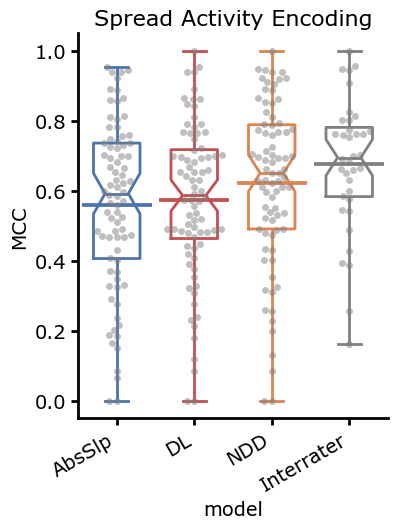

In [42]:
_,ax = plt.subplots(figsize=(4,5))
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[0,3,1]]
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray', order = ['AbsSlp','DL','NDD','Interrater'],ax=ax,alpha=.5)
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','DL','NDD','Interrater'],marker='_',markersize=50,errorbar=None,ax=ax,
              estimator='mean')
sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','DL','NDD','Interrater'],width=.6,notch=True,fill=False,whis=100,ax=ax)
sns.despine()

plt.xticks(rotation=30,ha='right')
plt.ylabel('MCC')
plt.title("Spread Activity Encoding")
plt.savefig(ospj(figpath,'spread_tuned_spread_detection.pdf'),bbox_inches='tight')

In [43]:
all_ps = []
for i_mdl in val_tuned_thresholds.model.unique():
    for j_mdl in val_tuned_thresholds.model.unique():
        if i_mdl==j_mdl:
            continue
        if (i_mdl != 'LSTM'):# & (j_mdl != 'LSTM'):
            continue
        print(i_mdl,j_mdl)
        print(np.mean(val_tuned_thresholds[val_tuned_thresholds.model == i_mdl]['dice']), np.mean(val_tuned_thresholds[val_tuned_thresholds.model == j_mdl]['dice']))
        
        p = sc.stats.mannwhitneyu(val_tuned_thresholds[val_tuned_thresholds.model == i_mdl]['dice'],val_tuned_thresholds[val_tuned_thresholds.model == j_mdl]['dice'],alternative='greater')
        d=cohens_d(val_tuned_thresholds[val_tuned_thresholds.model == i_mdl]['dice'],
                 val_tuned_thresholds[val_tuned_thresholds.model == j_mdl]['dice'])
        print(d)
        all_ps.append(p[1])
        print(p)
multipletests(all_ps)

LSTM AbsSlp
0.6237232137176523 0.5605173526004605
0.2672945579893008
MannwhitneyuResult(statistic=3697.5, pvalue=0.04493325545016304)
LSTM WVNT
0.6237232137176523 0.573689537950078
0.22002092778255108
MannwhitneyuResult(statistic=3663.5, pvalue=0.05704396235619582)


(array([False, False]),
 array([0.08784751, 0.08784751]),
 0.025320565519103666,
 0.025)

### Tuning at the patient level

In [44]:
# Group by 'Patient', 'model', and 'threshold' to calculate the average dice score for each threshold
avg_dice_per_threshold = tune_preds_long.groupby(['Patient', 'model', 'threshold','stim'])['dice'].mean().reset_index()

# Now, for each 'Patient' and 'model', find the threshold that maximizes the average dice score
threshold_list = avg_dice_per_threshold.loc[avg_dice_per_threshold.groupby(['Patient', 'model','stim'])['dice'].idxmax()]

# The result will contain the patient, model, threshold, and the average dice score
threshold_list_stim_spec = threshold_list[['Patient', 'model', 'stim','threshold']].reset_index(drop=True)

In [ ]:
# threshold_list_stim_spec.to_pickle(ospj(prodatapath,'patient_tuned_classification_thresholds_stim_sz-mean.pkl'))

In [ ]:
tuned_thresholds = tune_preds_long[tune_preds_long.set_index(['Patient', 'model', 'stim','threshold']).index.isin(threshold_list_stim_spec.set_index(['Patient', 'model', 'stim','threshold']).index)]
val_tuned_thresholds = val_preds_long[val_preds_long.set_index(['Patient', 'model', 'stim', 'threshold']).index.isin(threshold_list_stim_spec.set_index(['Patient', 'model', 'stim','threshold']).index)]

In [48]:
tuned_thresholds = tune_preds_long.merge(threshold_list[['Patient', 'model', 'threshold']],on=['Patient', 'model', 'threshold'],how='inner').reset_index()
tuned_thresholds_stim = tune_preds_long.merge(threshold_list_stim_spec[['Patient', 'model', 'stim','threshold']],on=['Patient', 'model', 'stim','threshold'],how='inner').reset_index()

In [49]:
tuned_thresholds_stim[(tuned_thresholds_stim.Patient=='HUP235')]

,index,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,...,ueo_chs_loose_bool,ueo_chs_loose_consensus_MCC,ueo_chs_loose_any_MCC,sec_chs_strict_bool,sec_chs_strict_any_MCC,sec_chs_loose_bool,sec_chs_loose_consensus_MCC,sec_chs_loose_any_MCC,annot,dice
93,93,HUP235,HUP235_phaseII,AbsSlp,1.0,17776.0000,17776.0000,0.213618,"[LA01, LA02, LA06, LB01, LB02, LB03, LB04, LB0...","[LA01, LA02, LA03, LA06, LA07, LB01, LB02, LB0...",...,"[True, True, True, False, False, True, True, F...",0.703873,0.734995,"[True, True, False, False, False, True, False,...",0.545270,"[True, True, True, False, False, True, True, F...",0.653322,0.456065,ueo_chs_strict_consensus_MCC,0.772544
94,94,HUP235,HUP235_phaseII,WVNT,1.0,17776.0000,17776.0000,0.598131,"[LA01, LA02, LB01, LB02, LB03, LB04, LB05, LC0...","[LA01, LA02, LA03, LB01, LB02, LB03, LB04, LB0...",...,"[True, True, True, False, False, False, False,...",0.770602,0.804674,"[True, True, False, False, False, True, False,...",0.513814,"[True, True, True, False, False, True, True, F...",0.454290,0.492965,ueo_chs_strict_consensus_MCC,0.835234
95,95,HUP235,HUP235_phaseII,LSTM,1.0,17776.0000,17776.0000,3.001335,"[LA01, LA02, LB01, LB02, LB03, LB04, LB05, LC0...","[LA01, LA02, LA03, LB01, LB02, LB03, LB04, LB0...",...,"[True, True, True, False, False, False, False,...",0.852609,0.890307,"[True, True, False, False, False, True, False,...",0.605890,"[True, True, True, False, False, True, True, F...",0.692052,0.500755,ueo_chs_strict_consensus_MCC,0.910731
96,96,HUP235,HUP235_phaseII,AbsSlp,0.0,107374.2078,107374.2078,0.122830,[LC01],"[LC01, LC02]",...,"[False, False, False, False, False, False, Fal...",0.489130,0.489130,"[False, True, False, False, False, False, Fals...",0.332486,"[False, True, True, False, False, False, False...",0.390924,0.252323,ueo_chs_strict_consensus_MCC,0.703295
97,97,HUP235,HUP235_phaseII,AbsSlp,0.0,126735.8100,126735.8100,0.122830,"[LC01, LC02, LC03]","[LC01, LC02, LC03, LC04]",...,"[False, False, False, False, False, False, Fal...",0.491869,0.261566,"[False, True, False, True, False, False, False...",0.192964,"[False, True, True, True, True, False, False, ...",0.314866,0.131280,ueo_chs_strict_consensus_MCC,0.571108
98,98,HUP235,HUP235_phaseII,AbsSlp,0.0,497084.3746,497084.3746,0.122830,"[LC01, LS04, LS05]","[LC01, LC02, LS04, LS05, LS06]",...,"[False, False, False, False, False, False, Fal...",0.437490,0.437490,"[False, True, False, False, False, False, Fals...",0.300294,"[False, True, True, False, False, False, False...",0.328109,0.328109,ueo_chs_strict_consensus_MCC,0.571108
99,99,HUP235,HUP235_phaseII,WVNT,0.0,107374.2078,107374.2078,0.379172,"[LB10, LC01]","[LB10, LB11, LC01, LC02]",...,"[False, False, False, False, False, False, Fal...",0.334148,0.334148,"[False, False, False, True, True, False, False...",0.352775,"[False, False, False, True, True, True, False,...",0.303390,0.304950,ueo_chs_strict_consensus_MCC,0.489130
100,100,HUP235,HUP235_phaseII,WVNT,0.0,126735.8100,126735.8100,0.379172,[LC01],"[LC01, LC02]",...,"[False, False, False, False, False, False, Fal...",0.703295,0.392638,"[False, False, False, True, True, True, False,...",0.420522,"[False, False, False, True, True, True, True, ...",0.294189,0.329872,ueo_chs_strict_consensus_MCC,1.000000
101,101,HUP235,HUP235_phaseII,WVNT,0.0,497084.3746,497084.3746,0.379172,[LC01],"[LC01, LC02]",...,"[False, False, False, False, False, False, Fal...",0.703295,0.703295,"[True, True, False, True, True, False, False, ...",0.354852,"[True, True, True, True, True, True, False, Fa...",0.252667,0.252667,ueo_chs_strict_consensus_MCC,1.000000
102,102,HUP235,HUP235_phaseII,LSTM,0.0,107374.2078,107374.2078,2.296395,[LC01],"[LC01, LC02]",...,"[False, False, False, False, False, False, Fal...",0.489130,0.489130,"[True, False, False, False, False, False, Fals...",0.943086,"[True, True, False, False, False, False, False...",0.624188,0.777844,ueo_chs_strict_consensus_MCC,0.703295


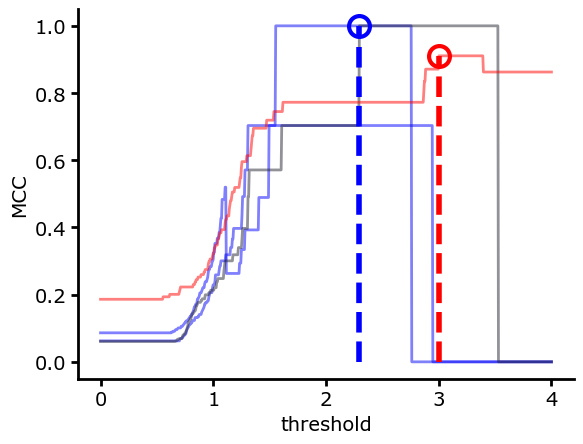

In [50]:
plot_pt = 'HUP235'

ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC') &
 (mdl_preds_long.model == 'LSTM') & 
 (mdl_preds_long.Patient == plot_pt) & 
 (mdl_preds_long.stim == 0)],x='threshold',y='dice',hue='approximate_onset', palette = 'dark:b_r', errorbar=None,legend=False,alpha=0.5)
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC') &
 (mdl_preds_long.model == 'LSTM') & 
 (mdl_preds_long.Patient == plot_pt) & 
 (mdl_preds_long.stim == 1)],x='threshold',y='dice', color = 'red', errorbar=None,legend=False,alpha=0.5)
# plt.xlim([0,1])
plt.ylabel('MCC')
ax.plot([threshold_list_stim_spec[(threshold_list_stim_spec.Patient==plot_pt) & 
(threshold_list_stim_spec.model=='LSTM') & 
(threshold_list_stim_spec.stim==0)].threshold.values]*2,[0,1],'--o',c='blue',
markersize=15,
linewidth=4,
markevery=[1],
fillstyle='none',
markeredgewidth=3)
ax.plot([
    threshold_list_stim_spec[(threshold_list_stim_spec.Patient==plot_pt) & 
    (threshold_list_stim_spec.model=='LSTM') & 
    (threshold_list_stim_spec.stim==1)
    ].threshold.values]*2,
    [0,
    tuned_thresholds_stim[(tuned_thresholds_stim.model=='LSTM') & 
    (tuned_thresholds_stim.Patient==plot_pt) & 
    (tuned_thresholds_stim.stim==1)
    ].dice.values[0]
    ],
'--o',
c='red',
markersize=15,
linewidth=4,
markevery=[1],
fillstyle='none',
markeredgewidth=3)
# plt.title('Clinician - AbsSlp agreement (HUP238)')
sns.despine()
plt.savefig(ospj(figpath,'pt_threshold_tuning_method.pdf'),bbox_inches='tight')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:7.323e-03 U_stat=1.775e+02
Average Optimal Spontaneous Threshold: 1.6060201480762224
LeveneResult(statistic=12.716684939743272, pvalue=0.0008208832196602245)


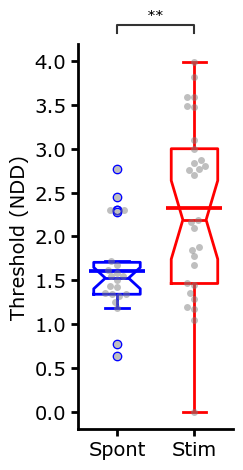

In [51]:
_,ax = plt.subplots(figsize=(2,5))
# colors = np.array(sns.color_palette("deep", 4))
# colors = colors[[1,1]]

plot_thresholds = threshold_list_stim_spec[threshold_list_stim_spec.model == 'LSTM']
sns.swarmplot(plot_thresholds,x='stim',y='threshold',color='gray',alpha=0.5)
sns.pointplot(plot_thresholds,x='stim',y='threshold',palette=['blue','red'],
            marker='_',markersize=40,errorbar=None,estimator='mean')
sns.boxplot(plot_thresholds,x='stim',y='threshold',palette=['blue','red'],width=.6,notch=True,fill=False)
sns.despine()
plt.xticks([0,1],['Spont','Stim'])
# plt.title("Ictal Transition Encoding - Patient Threshold")
plt.xlabel('')
plt.ylabel('Threshold (NDD)')
annotator = Annotator(ax,[(True,False)],data=plot_thresholds,x='stim',y='threshold')
annotator.configure(test='Mann-Whitney',loc='outside',text_format='star')
annotator.apply_and_annotate()
plt.savefig(ospj(figpath,'stim_vs_spont_thresholds.pdf'),bbox_inches='tight')
print(f'Average Optimal Spontaneous Threshold: {plot_thresholds[plot_thresholds.stim == 0].threshold.mean()}')
print(sc.stats.levene(plot_thresholds[plot_thresholds.stim==0].threshold,
plot_thresholds[plot_thresholds.stim==1].threshold))

#### Onset

In [54]:
all_plot_agreements = pd.concat([tuned_thresholds_stim,consensus_annots[["model","dice"]]]).reset_index()

In [55]:
for mdl in all_plot_agreements.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(consensus_annots.dice.dropna(),all_plot_agreements[all_plot_agreements.model == mdl].dice,alternative='greater'))
    print(cohens_d(consensus_annots.dice.dropna(),all_plot_agreements[all_plot_agreements.model == mdl].dice))

AbsSlp
MannwhitneyuResult(statistic=3994.0, pvalue=1.618323345765595e-07)
0.9251499408851594
WVNT
MannwhitneyuResult(statistic=3841.5, pvalue=3.155001769179562e-06)
0.7759526078908113
LSTM
MannwhitneyuResult(statistic=3366.0, pvalue=0.0038343299890245676)
0.4433123952246465
Clin.
MannwhitneyuResult(statistic=nan, pvalue=nan)
4.630752958978353e-16


In [56]:
all_plot_agreements = all_plot_agreements[all_plot_agreements.model != 'NRG']
all_plot_agreements.loc[all_plot_agreements.model == 'LSTM',['model']] = 'NDD'
all_plot_agreements.loc[all_plot_agreements.model == 'WVNT',['model']] = 'DL'
all_plot_agreements.loc[all_plot_agreements.model == 'Clin.',['model']] = 'Interrater'

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DL vs. NDD: One-sided MannWhitney U statistical test with Benjamini-Hochberg correction, P_val:1.891e-02 Stat=2.591e+03
AbsSlp vs. NDD: One-sided MannWhitney U statistical test with Benjamini-Hochberg correction, P_val:4.000e-03 Stat=2.422e+03


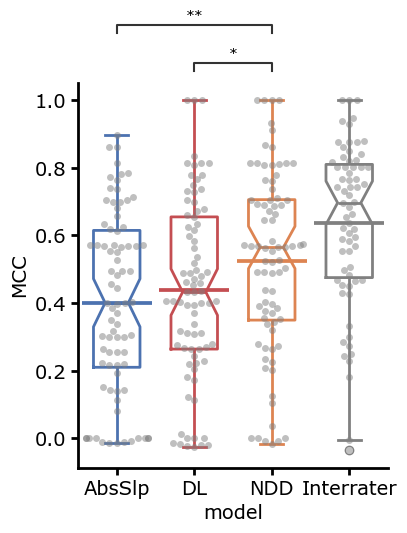

In [57]:
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[0,3,1]]
_,ax = plt.subplots(figsize=(4,5))
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray', order = ['AbsSlp','DL','NDD','Interrater'],alpha=0.5)
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','DL','NDD','Interrater'],marker='_',markersize=50,errorbar=None)
sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','DL','NDD','Interrater'],width=.6,notch=True,fill=False)
sns.despine()

# Required descriptors for annotate
custom_long_name = 'One-sided MannWhitney U statistical test'
custom_short_name = 'MWUG'
def custom_stat(x,y):
    return sc.stats.mannwhitneyu(x,y,alternative='less')
custom_test = StatTest(custom_stat, custom_long_name, custom_short_name)

# Annotating plot
annotator = Annotator(ax,[('NDD','DL'),('NDD','AbsSlp')],data=all_plot_agreements,x='model',y='dice')
annotator.configure(test=custom_test,loc='outside',text_format='star',comparisons_correction="Benjamini-Hochberg")
annotator.apply_and_annotate()

# plt.title("Onset Activity Encoding - Patient Threshold")
plt.ylabel("MCC")
plt.savefig(ospj(figpath,'patient_tuned_onset_detection.pdf'),bbox_inches='tight')

In [58]:
all_ps = []
mdl_strs = all_plot_agreements.model.unique()
for idx_mdl in range(len(mdl_strs)):
    for jdx_mdl in range(idx_mdl+1,len(mdl_strs)):
        i_mdl = mdl_strs[idx_mdl]
        j_mdl = mdl_strs[jdx_mdl]
        if (i_mdl != 'NDD') & (j_mdl != 'NDD'):
            continue
        print(i_mdl,j_mdl)
        _,p = sc.stats.ttest_ind(all_plot_agreements[all_plot_agreements.model == i_mdl]['dice'],all_plot_agreements[all_plot_agreements.model == j_mdl]['dice'])
        d=cohens_d(all_plot_agreements[all_plot_agreements.model == i_mdl]['dice'],
                 all_plot_agreements[all_plot_agreements.model == j_mdl]['dice'])
        all_ps.append(p)
        print(p)
_,p = sc.stats.mannwhitneyu(all_plot_agreements[all_plot_agreements.model == 'NDD'].dice,consensus_annots.f1)
print(p)
multipletests(all_ps[:2])

AbsSlp NDD
0.004571080599623078
DL NDD
0.04778431203996083
NDD Interrater
nan
nan


(array([ True,  True]),
 array([0.00912127, 0.04778431]),
 0.025320565519103666,
 0.025)

#### Stim vs. Spont

In [59]:
print(cohens_d(all_plot_agreements[(all_plot_agreements.stim == 0) & (all_plot_agreements.model == 'NDD')].dice,
all_plot_agreements[(all_plot_agreements.stim == 1) & (all_plot_agreements.model == 'NDD')].dice))
sc.stats.mannwhitneyu(all_plot_agreements[(all_plot_agreements.stim == 0) & (all_plot_agreements.model == 'NDD')].dice,
all_plot_agreements[(all_plot_agreements.stim == 1) & (all_plot_agreements.model == 'NDD')].dice)

0.16891594912463107


MannwhitneyuResult(statistic=867.0, pvalue=0.47118295390892007)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:4.712e-01 U_stat=8.670e+02


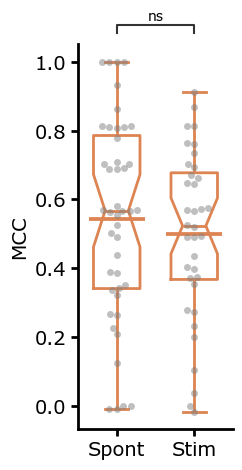

In [60]:
fig,ax=plt.subplots(figsize=(2,5))
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[1,1]]
stim_plot_agreements = all_plot_agreements[all_plot_agreements.model == 'NDD']
sns.swarmplot(stim_plot_agreements,x='stim',y='dice',color='gray',alpha=0.5)
sns.pointplot(stim_plot_agreements,x='stim',y='dice',palette=colors,
            marker='_',markersize=40,errorbar=None,estimator='mean')
sns.boxplot(stim_plot_agreements,x='stim',y='dice',palette=colors,width=.6,notch=True,fill=False)
sns.despine()
plt.xticks([0,1],['Spont','Stim'])
# plt.title("Ictal Transition Encoding - Patient Threshold")
plt.xlabel('')
plt.ylabel('MCC')
annotator = Annotator(ax,[(True,False)],data=stim_plot_agreements,x='stim',y='dice')
annotator.configure(test='Mann-Whitney',loc='outside',text_format='star')
annotator.apply_and_annotate()
plt.savefig(ospj(figpath,'stim_vs_spont_detection.pdf'),bbox_inches='tight')

#### Spread

In [61]:
all_plot_agreements = pd.concat([val_tuned_thresholds,spread_consensus_annots[["model","dice"]]])
all_plot_agreements = all_plot_agreements[all_plot_agreements.model != 'NRG']

In [62]:
for mdl in val_tuned_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(spread_consensus_annots.f1,val_tuned_thresholds[val_tuned_thresholds.model == mdl].dice))

AbsSlp
MannwhitneyuResult(statistic=nan, pvalue=nan)
WVNT
MannwhitneyuResult(statistic=nan, pvalue=nan)
LSTM
MannwhitneyuResult(statistic=nan, pvalue=nan)


Text(0.5, 1.0, 'Patient-level Optimal Onset Thresholds Detecting Spread')

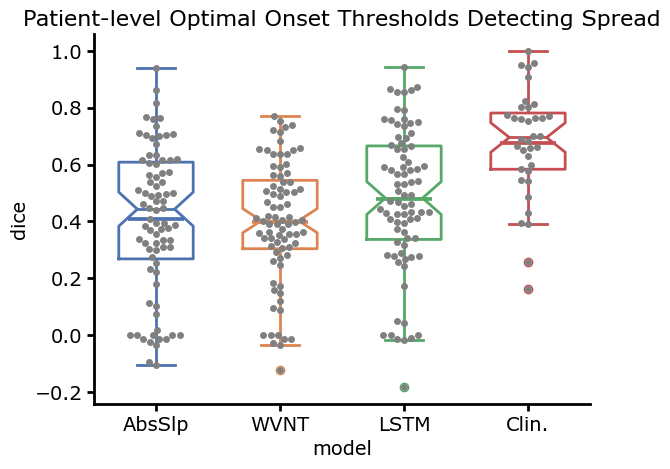

In [63]:
colors = sns.color_palette("deep", 4)
bx = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','WVNT','LSTM','Clin.'],width=.6,notch=True,fill=False)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray')
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','WVNT','LSTM','Clin.'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title("Patient-level Optimal Onset Thresholds Detecting Spread")

## Unsupervised Model Predictions

In [64]:
# Loading in human annotations with consensus annotation already created
annotations_df = pd.read_pickle(ospj(prodatapath,"threshold_tuning_consensus.pkl"))
# annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# Loading in predicted channels for all models from generate_model_annotations.py
# predicted_channels = pd.read_pickle(ospj(prodatapath,"gamma_predicted_channels_opt.pkl"))
# predicted_channels = pd.read_pickle(ospj(prodatapath,"kdeknee_predicted_channels_nor.pkl"))
predicted_channels = pd.read_pickle(ospj(prodatapath,"DynaSD_gaussianx_automedian_predicted_channels_norp_valtuned_v2.pkl"))
# predicted_channels = pd.read_pickle(ospj(prodatapath,"DynaSD_90centile_predicted_channels_nor.pkl"))


# predicted_channels = 
predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]
predicted_channels.loc[predicted_channels.approximate_onset == 439029.32,'stim'] = 1

# Sorting
predicted_channels.sort_values('approximate_onset',inplace=True)
predicted_channels = predicted_channels[(predicted_channels.stim == 0)]# & predicted_channels.Patient.apply(lambda x: 'HUP' in x)]
annotations_df.sort_values('approximate_onset',inplace=True)
predicted_channels['patient'] = predicted_channels.pop('Patient')

# Creating a merged table with human and machine annotations based on approximate seizure onset time
pred_channels_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
                                    on='approximate_onset',by='patient',
                                    tolerance = 240,
                                    direction='nearest')
pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
pred_channels_wannots.sort_values(['patient','approximate_onset'],inplace=True)
# pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
pred_channels_wdice = pred_channels_wannots.apply(apply_mcc,axis=1)
# pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)

In [65]:
consensus_annots = pd.read_pickle(ospj(prodatapath,'threshold_tuning_consensus.pkl'))
consensus_annots.loc[consensus_annots.Seizure_ID == 'HUP249_3','stim'] = 1.0
consensus_annots = consensus_annots[consensus_annots.patient != 'CHOP038']

consensus_annots = consensus_annots[consensus_annots.clinician.apply(lambda x: len(x)!=2)]
spread_consensus_annots = consensus_annots.copy()
note_type = 'ueo'
for i_r, row in consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]
    if len(annots) < 2: 
        continue
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += matthews_corrcoef(annots[i_annot],annots[j_annot])
    consensus_annots.loc[i_r,'f1'] = scores/(len(annots)*(len(annots)-1)/2)
consensus_annots["model"] = ["Interrater"]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]

In [66]:
# pred_channels_wdice = pred_channels_wdice[pred_channels_wdice.ueo_consensus_loose_dice > 0]
# pred_channels_wdice = pred_channels_wdice[pred_channels_wdice.ueo_chs_strict.apply(lambda x: len(x) > 0)]

In [67]:
print(len(pred_channels_wdice.patient.unique()),len(pred_channels_wdice.approximate_onset.unique()))

21 43


In [68]:
pred_type = 'ueo_chs_strict_consensus_MCC'
# pred_type = 'ueo_consensus_strict_dice'
pred_channels_wdice['dice'] = pred_channels_wdice[pred_type]
# consensus_annots['dice'] = consensus_annots['MCC']

In [69]:
pred_channels_wdice = pd.concat([pred_channels_wdice,consensus_annots[consensus_annots.stim == 0]]).reset_index(drop=True)
pred_channels_wdice.loc[pred_channels_wdice.model == 'LSTM','model'] = 'NDD'

In [70]:
pred_channels_wdice

,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,...,sec_chs_loose_consensus_MCC,sec_chs_loose_any_MCC,dice,Seizure_ID,clinician,ueo,ueo_time,sec,offset,f1
0,CHOP041,NDD,0.0,416768.1800,416768.18000,2.127127,"[LB01, LE08, LJ08, LJ09, LJ10, LP08, LS05, LE0...","[LB01, LB02, LE07, LE08, LE09, LI04, LI05, LI0...",[LH04],"[LH04, LH05]",...,0.133822,0.133822,0.147508,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CHOP049,NDD,0.0,114973.4900,114973.49000,1.331594,"[LF01, LM01, LC07, LC06, LC05, LC04, LC03, LC0...","[LA07, LA08, LA09, LC01, LC02, LC03, LC04, LC0...",[],[],...,0.000000,0.000000,0.272833,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HUP224_phaseII,NDD,0.0,339143.6435,339143.64350,1.532844,"[LA01, RC04, RC03, RC02, RC01, RB03, RB02, RB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[LA08, RX03]","[LA08, LA09, RX03, RX04]",...,-0.031213,-0.036377,0.458437,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HUP224_phaseII,NDD,0.0,491467.8046,491467.80460,1.749758,"[LA01, RX01, RC04, RC03, RC02, RC01, RB03, RB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...",[LC05],"[LC05, LC06]",...,-0.021974,-0.025609,0.439590,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HUP224_phaseII,NDD,0.0,519177.9500,519177.95000,1.516279,"[RA04, RC03, RC01, RB03, RB02, RB01, RA05, RA0...","[LB03, LB04, LB05, LB06, RA01, RA02, RA04, RA0...","[LA07, LC05, LI03]","[LA07, LA08, LC05, LC06, LI03, LI04]",...,-0.038398,-0.046237,0.730260,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,HUP266_phaseII,Interrater,0.0,418859.4191,418858.25980,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.454348,HUP266_4,"[CK, DZ, JJ]","[[False, False, False, False, False, False, Fa...","[418858.18, 418858.2598, 418858.29]","[[False, True, False, False, False, False, Fal...",418924.84,0.454348
82,HUP267b_phaseII,Interrater,0.0,49987.0900,49984.69870,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,HUP267_2,[DZ],"[[False, False, False, False, False, False, Fa...",[49984.6987],"[[True, True, True, True, False, False, False,...",50058.31,NaN
83,HUP273c_phaseII,Interrater,0.0,233275.1000,233282.37000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,HUP273_3,[EC],"[[False, False, False, False, False, False, Fa...",[233282.37],"[[False, False, False, False, False, False, Fa...",233367.08,NaN
84,HUP275_phaseII,Interrater,0.0,297659.4400,297660.13984,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,HUP275_3,[DZ],"[[False, False, False, False, False, False, Fa...",[297660.13984],"[[False, False, False, False, False, False, Fa...",297715.26,NaN


### Combining unsupervised detections

In [71]:
# unsupervised_df_wdice = pd.concat([pred_channels_wdice[pred_channels_wdice.model != 'Ext. Clin.'],absslp_df,wvnt_df]).reset_index()
pred_channels_wdice_u = pred_channels_wdice.copy()
pred_channels_wdice_u.loc[pred_channels_wdice_u.model == 'NDD','model'] = 'uNDD'
unsupervised_df_wdice = pd.concat([pred_channels_wdice_u[pred_channels_wdice_u.model != 'Ext. Clin.'],cval_plot_agreements])
unsupervised_df_wdice.loc[unsupervised_df_wdice.model == 'WVNT',['model']] = 'DL'
unsupervised_df_wdice = unsupervised_df_wdice[unsupervised_df_wdice.stim == 0]
unsupervised_df_wdice['dice'] = unsupervised_df_wdice['dice'].astype(float)
unsupervised_df_wdice.dropna(subset='dice',inplace=True)

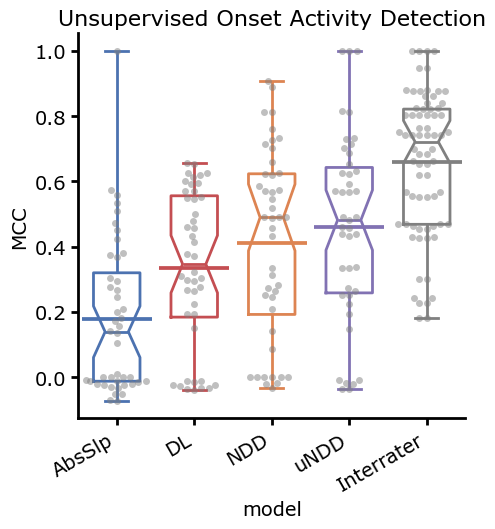

In [72]:
colors = np.array(sns.color_palette("deep", 5))
colors = colors[[0,3,1,4]]
_,ax = plt.subplots(figsize=(5,5))
sns.boxplot(unsupervised_df_wdice,x='model',y='dice',hue='model',palette=np.vstack([colors,[.5,.5,.5]]),
                 order=['AbsSlp','DL','NDD','uNDD','Interrater'],
                 hue_order=['AbsSlp','DL','NDD','uNDD','Interrater'],
                 width=.6,notch=True,fill=False,
                 ax=ax,
                 whis=100)

sns.swarmplot(unsupervised_df_wdice,x='model',y='dice',color='gray',ax=ax,alpha=0.5)
sns.pointplot(unsupervised_df_wdice,x='model',y='dice',
              palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              hue_order = ['AbsSlp','DL','NDD','uNDD','Interrater'],
              order = ['AbsSlp','DL','NDD','uNDD','Interrater'],
              marker='_',markersize=50,errorbar=None,
              estimator='mean',
              ax=ax)

sns.despine()
plt.xticks(rotation=30,ha='right')
plt.ylabel('MCC')
plt.title('Unsupervised Onset Activity Detection')
plt.savefig(ospj(figpath,'unsupervised_onset_detection.pdf'),bbox_inches='tight')

In [73]:
all_ps = []
mdl_strs = unsupervised_df_wdice.model.unique()
for idx_mdl in range(len(mdl_strs)):
    for jdx_mdl in range(idx_mdl+1,len(mdl_strs)):
        i_mdl = mdl_strs[idx_mdl]
        j_mdl = mdl_strs[jdx_mdl]
        if (i_mdl != 'uNDD') & (j_mdl != 'uNDD'):
            continue
        print(i_mdl,j_mdl)
        print(np.median(unsupervised_df_wdice[unsupervised_df_wdice.model == i_mdl]['dice']), np.median(unsupervised_df_wdice[unsupervised_df_wdice.model == j_mdl]['dice']))
        stat,p = sc.stats.mannwhitneyu(unsupervised_df_wdice[unsupervised_df_wdice.model == i_mdl].dice,unsupervised_df_wdice[unsupervised_df_wdice.model == j_mdl].dice,alternative='greater')
        d=cohens_d(unsupervised_df_wdice[unsupervised_df_wdice.model == i_mdl]['dice'],
                 unsupervised_df_wdice[unsupervised_df_wdice.model == j_mdl]['dice'])
        all_ps.append(p)
        print(stat,p)
multipletests(all_ps[1:])

uNDD Interrater
0.4814552754323709 0.7210389629780226
906.0 0.9998983559628088
uNDD AbsSlp
0.4814552754323709 0.1391830883222735
1469.5 4.487485096326175e-06
uNDD NDD
0.4814552754323709 0.48958132856941056
1001.5 0.3202347701550133
uNDD DL
0.4814552754323709 0.34651116538268756
1191.5 0.018757251044528002


(array([ True, False,  True]),
 array([1.34623949e-05, 3.20234770e-01, 3.71626676e-02]),
 0.016952427508441503,
 0.016666666666666666)

In [74]:
x = unsupervised_df_wdice.sort_values('approximate_onset')
x

,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,...,sec_chs_loose_consensus_MCC,sec_chs_loose_any_MCC,dice,Seizure_ID,clinician,ueo,ueo_time,sec,offset,f1
20,NaN,AbsSlp,0.0,20694.88,NaN,0.128171,NaN,NaN,NaN,NaN,...,NaN,NaN,0.373303,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,DL,0.0,20694.88,NaN,0.299065,NaN,NaN,NaN,NaN,...,NaN,NaN,0.596285,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,NaN,NDD,0.0,20694.88,NaN,1.495327,NaN,NaN,NaN,NaN,...,NaN,NaN,0.619230,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,HUP247_phaseII,Interrater,0.0,20694.88,20694.79136,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.428104,HUP247_2,"[DZ, JJ, JK]","[[True, True, True, False, False, False, False...","[20694.79136, 20694.82, 20692.79]","[[True, True, True, True, False, False, False,...",20721.33,0.428104
19,HUP247_phaseII,uNDD,0.0,20694.88,20694.88000,1.429526,"[RP01, RW06, RW03, RV07, RV06, RV08, RV04, RP0...","[RP01, RP02, RP03, RP04, RV04, RV05, RV06, RV0...",[RX04],"[RX04, RX05]",...,-0.1066,-0.137102,0.571739,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,NaN,Interrater,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.802818,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164,NaN,Interrater,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.947926,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165,NaN,Interrater,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.802666,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,NaN,Interrater,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.299405,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Onset Localization

In [75]:
ndd_vals = pd.read_pickle(ospj(prodatapath,"NDD_soz_localizations_nosmooth.pkl"))

In [76]:
consensus_annots['ueo_chs'] = consensus_annots.apply(lambda x: np.array(x.all_chs)[x.ueo_consensus],axis=1)
consensus_annots['sec_chs'] = consensus_annots.apply(lambda x: np.array(x.all_chs)[x.sec_consensus],axis=1)

In [77]:
consensus_annots

,Seizure_ID,clinician,patient,ueo,ueo_time,sec,all_chs,iEEG_ID,approximate_onset,offset,...,ueo_consensus,ueo_any,ueo_time_consensus,sec_consensus,sec_any,f1,model,dice,ueo_chs,sec_chs
0,CHOP005_1,"[CK, JJ, JK]",CHOP005,"[[False, False, False, False, False, False, Fa...","[68881.44, 68881.52, 68881.26]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA02, LA03, LA04, LA05, LA06, LA0...",CHOP005,68881.53000,68944.57,...,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",68881.44000,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",0.766309,Interrater,0.766309,"[LK01, LK02, LK03, LK04]","[LH01, LH02, LK01, LK02, LK03, LK04, LL03]"
1,CHOP010_1,"[DZ, EC, JK]",CHOP010,"[[False, False, False, False, False, False, Fa...","[2232.773277, 2232.6, 2232.77]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_010,2230.26000,2267.78,...,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2232.77000,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",0.274132,Interrater,0.274132,"[RH02, RH03, RH04, RH05, RI02, RI03]","[RG01, RG02, RG03, RG04, RH03, RH04, RH05, RI0..."
2,CHOP015_1,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[77180.36, 77180.95, 77190.4]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_015,77190.79000,77225.07,...,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",77180.95000,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",-0.034864,Interrater,-0.034864,[],"[LD10, LD11, LE07, LE08, LE09, LF09, LI03, LI0..."
3,CHOP015_2,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[81584.13, 81587.68, 81587.23]","[[False, False, False, True, True, False, Fals...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_015,81585.72000,81614.99,...,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",81587.23000,"[False, False, False, True, True, False, False...","[False, False, True, True, True, True, False, ...",0.662438,Interrater,0.662438,[LC09],"[LA04, LA05, LC08, LC09, LC10]"
4,CHOP024_1,"[CK, DZ, JJ]",CHOP024,"[[False, False, False, False, False, False, Fa...","[87577.58, 875775.9034, 87576.74]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA02, LA03, LA04, LA05, LA06, LA0...",CHOPCCEP_024,87579.25000,87591.61,...,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",87577.58000,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",0.332904,Interrater,0.332904,"[LE10, LF02, LF03, LF04, LF05]",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,HUP275_1,[DZ],HUP275,"[[False, False, False, False, False, False, Fa...",[32469.14025],"[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",HUP275_CCEP,32467.00000,32518.51,...,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",32469.14025,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",NaN,Interrater,NaN,"[RA01, RA02, RA03, RA04, RB01, RB02]","[RA01, RA02, RA03, RA04, RB01, RB02, RB03]"
81,HUP275_2,[DZ],HUP275,"[[False, False, False, False, False, False, Fa...",[32917.11728],"[[True, True, True, False, False, False, False...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",HUP275_CCEP,32916.30078,32972.11,...,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, F

In [78]:
ndd_vals.sort_values('approximate_onset',inplace=True)
consensus_annots.sort_values('approximate_onset',inplace=True)
# Creating a merged table with human and machine annotations based on approximate seizure onset time
ndd_vals_wannots = pd.merge_asof(ndd_vals,
                                    consensus_annots[['approximate_onset','patient','ueo_chs','sec_chs','ueo_consensus','sec_consensus']],
                                    on='approximate_onset',by='patient',
                                    tolerance = 240,
                                    direction='nearest')

In [79]:
def ch_soz(row):
    chs = row.channel.split('-')
    soz = row.ueo_chs
    if isinstance(soz,float):
        return False
    if len(soz) == 0:
        return False
    elif chs[0] in soz:
        return True
    else:
        return False
def ch_ssz(row):
    chs = row.channel.split('-')
    soz = row.sec_chs
    if isinstance(soz,float):
        return False
    if len(soz) == 0:
        return False
    elif chs[0] in soz:
        return True
    else:
        return False

In [80]:
ndd_vals_wannots['soz'] = ndd_vals_wannots.apply(ch_soz,axis=1)
ndd_vals_wannots['ssz'] = ndd_vals_wannots.apply(ch_ssz,axis=1)

In [81]:
plt_ndd_vals = ndd_vals_wannots[ndd_vals_wannots.model == 'LSTM'].groupby(['patient','soz'])[['onset_ndd','spread_ndd']].mean().reset_index()

790.0 9.264828725166787e-10
0.9729064039408867
4.501017232718253 5.528510508524683
1.194797045747334 0.40386581420832224
1.5986628599556563


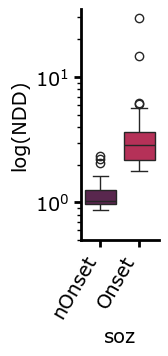

In [82]:
plt.figure(figsize=(1,3))
sns.boxplot(data=plt_ndd_vals,x='soz',y='onset_ndd',hue='soz',palette=sns.color_palette('rocket',n_colors=3)[:2],width=.8,legend=False)
sns.despine()
plt.xticks([0,1],['nOnset','Onset'],rotation=60,ha='right')
# plt.xlabel('SOZ')
plt.ylim([min(plt_ndd_vals.onset_ndd-.1),35])
plt.ylabel('log(NDD)')
plt.yscale('log')
plt.ylim([0.5,35])
mask1 = (plt_ndd_vals['soz'])
n1 = len(plt_ndd_vals[mask1])
n2 = len(plt_ndd_vals[~mask1])

u,p = sc.stats.mannwhitneyu(plt_ndd_vals[mask1].onset_ndd,plt_ndd_vals[~mask1].onset_ndd)
print(u,p)
print(u/(n1*n2))
print(plt_ndd_vals[mask1].onset_ndd.mean(), plt_ndd_vals[mask1].onset_ndd.std())
print(plt_ndd_vals[~mask1].onset_ndd.mean(), plt_ndd_vals[~mask1].onset_ndd.std())
print(plt_ndd_vals[~mask1].onset_ndd.mean() + plt_ndd_vals[~mask1].onset_ndd.std())
plt.savefig(ospj(figpath,'onset_localization.pdf'),bbox_inches='tight',transparent=True)

In [83]:
plt_ndd_vals = ndd_vals_wannots[ndd_vals_wannots.model == 'LSTM'].groupby(['patient','ssz'])[['onset_ndd','spread_ndd']].mean().reset_index()

5.090389345352894
1.2957444536901566
740.0 1.154855308072537e-08
0.9450830140485313


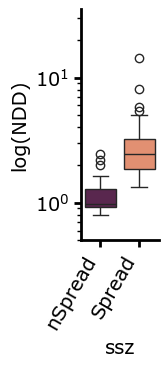

In [84]:
plt.figure(figsize=(1,3))
sns.boxplot(data=plt_ndd_vals,x='ssz',y='onset_ndd',hue='ssz',palette=sns.color_palette('rocket',n_colors=3)[::2],width=.8,legend=False)
sns.despine()
plt.xticks([0,1],['nSpread','Spread'],rotation=60,ha='right')
# plt.xlabel('SOZ')
plt.ylim([min(plt_ndd_vals.onset_ndd-.1),35])
plt.ylabel('log(NDD)')
plt.yscale('log')
plt.ylim([0.5,35])
mask1 = (plt_ndd_vals['ssz'])
n1 = len(plt_ndd_vals[mask1])
n2 = len(plt_ndd_vals[~mask1])
u,p = sc.stats.mannwhitneyu(plt_ndd_vals[mask1].spread_ndd,plt_ndd_vals[~mask1].spread_ndd);
print(plt_ndd_vals[mask1].spread_ndd.mean())
print(plt_ndd_vals[~mask1].spread_ndd.mean())
print(u,p)
print(u/(n1*n2))
plt.savefig(ospj(figpath,'spread_localization.pdf'),bbox_inches='tight',transparent=True)

## MCC evaluation

In [85]:
consensus_annots = pd.read_pickle(ospj(prodatapath,'threshold_tuning_consensus.pkl'))
consensus_annots = consensus_annots[consensus_annots.stim == 0]
consensus_annots = consensus_annots[consensus_annots.clinician.apply(lambda x: len(x)!=2)]
spread_consensus_annots = consensus_annots.copy()
note_type = 'ueo'
for i_r, row in consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]
    if len(annots) < 2:
        continue
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += matthews_corrcoef(annots[i_annot],annots[j_annot])
    consensus_annots.loc[i_r,'MCC'] = scores/(len(annots)*(len(annots)-1)/2)
consensus_annots["model"] = ["Clin."]*len(consensus_annots)

In [86]:
ndd_vals_wannots = ndd_vals_wannots[ndd_vals_wannots.model == 'LSTM']
ndd_vals_wannots = ndd_vals_wannots[ndd_vals_wannots.stim == 0]

CHOP024 175520.91
CHOP044 29018.38
HUP225 393496.2
HUP225 408576.508
0.5338201235997725 0.6543212352746101


MannwhitneyuResult(statistic=1030.0, pvalue=0.02571572894416929)

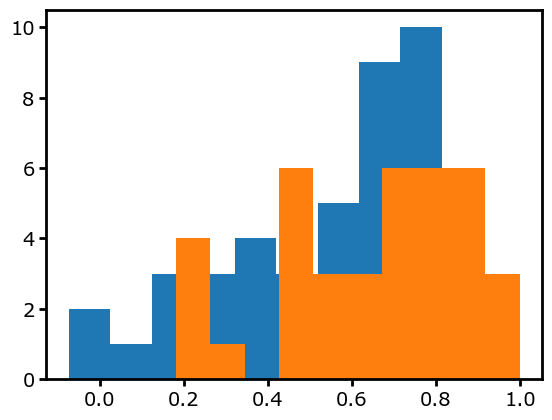

In [87]:
all_mccs = []
dict_list = []
for _,group in ndd_vals_wannots.groupby(['patient','approximate_onset','model']):
    # sns.lineplot(group,x='channel',y='soz')
    # sns.lineplot(group,x='channel',y='onset_ndd')
    r = group[['soz','onset_ndd']].corr().iloc[1,0]
    if np.isnan(r):
        print(group.patient.iloc[0],group.approximate_onset.iloc[0])
        continue
    dict_list.append({
        'patient': group.patient.iloc[0],
        'approximate_onset': group.approximate_onset.iloc[0]
        
    })
    all_mccs.append(r)
plt.hist(all_mccs)
plt.hist(consensus_annots['MCC'])
print(np.nanmean(all_mccs),np.nanmean(consensus_annots['MCC']))
sc.stats.mannwhitneyu(consensus_annots['MCC'][~consensus_annots.MCC.isna()],np.array(all_mccs)[~np.isnan(all_mccs)])

## Region Agreement

In [88]:
predicted_channels = pd.read_pickle(ospj(prodatapath,"pretrain_predicted_channels_norsc.pkl"))
predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

In [89]:
# Go through the already created combined dataframe.
annotations_df = consensus_annots.copy()
annotations_df['Patient'] = annotations_df['patient']
pt_groups = annotations_df.groupby('Patient')
for pt,group in pt_groups:
    try:
        electrode_localizations,electrode_regions = electrode_wrapper(pt,rid_hup,datapath)
    except:
        print(f'no regions for {pt}')
        continue
    for idx,row in group.iterrows():
        for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
            chs = np.array(row.all_chs)[row[col]]
            electrode_locals = electrode_regions[electrode_regions.name.isin(chs)]['label'].unique()
            annotations_df.at[idx,col+'_rs'] = electrode_locals
        annotations_df.at[idx,'all_rs'] = electrode_regions[electrode_regions.name.isin(row['all_chs'])]['label'].unique()
annotations_df.sort_values('approximate_onset',inplace=True)

no regions for CHOP015
no regions for CHOP038


In [90]:
pt_groups = predicted_channels.groupby('Patient')
for pt,group in pt_groups:
    try:
        electrode_localizations,electrode_regions = electrode_wrapper(pt,rid_hup,datapath)
    except:
        print(f'no regions for {pt}')
        continue
    for idx,row in group.iterrows():
        for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
            electrode_locals = electrode_regions[electrode_regions.name.isin(row[col])]['label'].unique()
            predicted_channels.at[idx,col.split('_')[0]+'_rs_'+col.split('_')[2]] = electrode_locals
predicted_channels.sort_values('approximate_onset',inplace=True)
pred_regions_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','Patient','all_rs','ueo_consensus_rs','ueo_any_rs','sec_consensus_rs','sec_any_rs']],
                                    on='approximate_onset',by='Patient',
                                    tolerance = 240,
                                    direction='nearest')
pred_regions_wannots.dropna(axis=0,subset='ueo_consensus_rs',inplace=True)
pred_regions_wannots.sort_values(['Patient','iEEG_ID','approximate_onset','threshold','model'],inplace=True)
# pred_regions_wkappa = pred_regions_wannots.apply(apply_region_kappa,axis=1)

KeyboardInterrupt: 

In [ ]:
pred_regions_wannots.to_pickle(ospj(prodatapath,'pred_regions_wannots.pkl'))

In [ ]:
pred_regions_wannots

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,to_annotate,ueo_rs_strict,ueo_rs_loose,sec_rs_strict,sec_rs_loose,all_rs,ueo_consensus_rs,ueo_any_rs,sec_consensus_rs,sec_any_rs
140497,CHOP041,CHOP041,AbsSlp,0.0,416768.18,416768.18,0.000000,"[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...","[LA01, LA02, LA04, LA05, LA06, LA07, LA08, LA0...","[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...",...,1.0,"[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[Left-Amygdala, Left-Cerebral-White-Matter, Le...","[Left-Amygdala, Left-Cerebral-White-Matter, Le..."
140997,CHOP041,CHOP041,LSTM,0.0,416768.18,416768.18,0.000000,"[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...","[LA01, LA02, LA04, LA05, LA06, LA07, LA08, LA0...","[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...",...,1.0,"[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[Left-Amygdala, Left-Cerebral-White-Matter, Le...","[Left-Amygdala, Left-Cerebral-White-Matter, Le..."
140999,CHOP041,CHOP041,NRG,0.0,416768.18,416768.18,0.000000,"[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...","[LA01, LA02, LA04, LA05, LA06, LA07, LA08, LA0...","[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...",...,1.0,"[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[Left-Amygdala, Left-Cerebral-White-Matter, Le...","[Left-Amygdala, Left-Cerebral-White-Matter, Le..."
141658,CHOP041,CHOP041,WVNT,0.0,416768.18,416768.18,0.000000,"[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...","[LA01, LA02, LA04, LA05, LA06, LA07, LA08, LA0...","[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...",...,1.0,"[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[Left-Amygdala, Left-Cerebral-White-Matter, Le...","[Left-Amygdala, Left-Cerebral-White-Matter, Le..."
140337,CHOP041,CHOP041,AbsSlp,0.0,416768.18,416768.18,0.006012,"[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...","[LA01, LA02, LA04, LA05, LA06, LA07, LA08, LA0...","[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...",...,1.0,"[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[Left-Amygdala, Left-Cerebral-White-Matter, Le...","[Left-Amygdala, Left-Cerebral-White-Matter, Le..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99999,HUP288,HUP288_phaseII,WVNT,0.0,251098.53,251098.53,2.993988,[],[],[],...,1.0,[],[],[],[],"[EmptyLabel, right inferior parietal , right...",[],[],[],[]
98997,HUP288,HUP288_phaseII,AbsSlp,

In [ ]:
pred_regions_wannots.apply(apply_region_dice,axis=1)

KeyError: 'ueo_consensus'

In [ ]:
def apply_region_dice(row):
    all_rs = row.all_rs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row